# Poker Agent V16: Long-Term Strategy Training

Key features:
- 6-player table (agent + 5 opponent types)
- **Session-based training** (20 hands per session)
- **All-in penalty system** (discourages gambling)
- **Bust detection** and penalties
- **Survival bonuses** for completing sessions
- Position-aware rewards
- Dynamic epsilon decay

In [1]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

from poker_worker_v16 import run_session_v16, POSITION_NAMES
from poker_model_v16 import (
    DuelingPokerNet, PrioritizedReplayBuffer, NUM_ACTIONS_V16,
    compute_hand_strength_category
)

In [2]:
# Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training config
NUM_WORKERS = 6
SESSIONS_PER_BATCH = 6
HANDS_PER_SESSION = 20
NUM_ACTIONS = NUM_ACTIONS_V16
STATE_DIM = 520  # Same as V15
EQUITY_ITERATIONS = 20

# Logging intervals (as percentage of total sessions)
LOG_PERCENT = 2.0
CHECKPOINT_PERCENT = 10.0

Using device: cuda


In [3]:
class DuelingAgent:
    """Dueling DQN agent with PER for 6-max poker."""
    
    def __init__(self, state_dim: int = 520, hidden_dim: int = 512):
        self.device = device
        self.policy_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=3e-4)
        self.buffer = PrioritizedReplayBuffer(capacity=500000)
        
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995  # Will be recalculated dynamically
    
    def get_model_state_dict_cpu(self):
        return {k: v.cpu() for k, v in self.policy_net.state_dict().items()}
    
    def add_transitions(self, transitions):
        self.buffer.push_batch(transitions)
    
    def train_step(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0.0
        
        samples, indices, weights = self.buffer.sample(self.batch_size)
        if not samples:
            return 0.0
        
        states = torch.FloatTensor(np.array([s[0] for s in samples])).to(self.device)
        actions = torch.LongTensor([s[1] for s in samples]).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in samples]).to(self.device)
        next_states = torch.FloatTensor(np.array([s[3] for s in samples])).to(self.device)
        dones = torch.FloatTensor([s[4] for s in samples]).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        
        # Current Q values
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets = rewards + self.gamma * next_q * (1 - dones)
        
        # Weighted loss
        td_errors = q_values - targets
        loss = (weights * td_errors.pow(2)).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors.detach().cpu().numpy())
        
        return loss.item()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [4]:
def train_v16_parallel(num_sessions=5000):
    """Train V16 agent with session-based training."""
    agent = DuelingAgent(state_dim=STATE_DIM)
    
    # Dynamic epsilon decay based on num_sessions
    total_batches = num_sessions // SESSIONS_PER_BATCH
    decay_batches = int(total_batches * 0.8)  # Reach min epsilon at 80% through training
    if decay_batches > 0:
        agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1.0 / decay_batches)
    
    # Tracking (same as V15)
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts_total = {i: 0 for i in range(NUM_ACTIONS)}
    
    # Position tracking
    position_stats = {pos: {'rewards': [], 'wins': 0, 'hands': 0} 
                      for pos in range(6)}
    
    # Risk metrics (V15 compatible)
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0}
    
    # V16 specific: session tracking
    session_metrics = {
        'bust_count': 0,
        'survival_count': 0,
        'allin_outcomes': [],  # Track all-in wins/losses
    }
    
    total_sessions = 0
    total_hands = 0
    batch_count = 0
    start_time = time.time()
    
    # Logging intervals
    log_interval = max(1, int(num_sessions * LOG_PERCENT / 100))
    checkpoint_interval = max(1, int(num_sessions * CHECKPOINT_PERCENT / 100))
    next_log = log_interval
    next_checkpoint = checkpoint_interval
    
    print("="*70)
    print(f"TRAINING V16: LONG-TERM STRATEGY ({NUM_WORKERS} workers)")
    print("="*70)
    print(f"Total sessions: {num_sessions:,}")
    print(f"Hands per session: {HANDS_PER_SESSION}")
    print(f"Total hands: {num_sessions * HANDS_PER_SESSION:,}")
    print(f"Sessions per batch: {SESSIONS_PER_BATCH}")
    print(f"Total batches: {total_batches:,}")
    print(f"State dimension: {STATE_DIM}")
    print(f"Action space: {NUM_ACTIONS} actions")
    
    print(f"\nEpsilon schedule (dynamic):")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at batch {decay_batches:,} (80% of training)")
    print(f"  Decay factor per batch: {agent.epsilon_decay:.6f}")
    
    print("\nV16 Features:")
    print("  - Session-based training (20 hands per session)")
    print("  - Severe all-in loss penalties")
    print("  - All-in frequency penalties")
    print("  - Bust penalty (-20 BB) and survival bonus")
    print("  - Risk-adjusted rewards")
    print("="*70)
    
    try:
        ctx = mp.get_context('fork')
        print("\nUsing 'fork' context for multiprocessing")
    except:
        ctx = mp.get_context('spawn')
        print("\nUsing 'spawn' context for multiprocessing")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_sessions < num_sessions:
            model_state_dict = agent.get_model_state_dict_cpu()
            
            # Prepare session arguments
            session_args = []
            for i in range(SESSIONS_PER_BATCH):
                seed = random.randint(0, 2**31-1)
                session_args.append((seed, agent.epsilon, EQUITY_ITERATIONS, 
                                     model_state_dict, HANDS_PER_SESSION))
            
            # Run sessions in parallel
            futures = [executor.submit(run_session_v16, args) for args in session_args]
            
            batch_rewards = []
            batch_profits = []
            batch_transitions = []
            batch_action_counts = {i: 0 for i in range(NUM_ACTIONS)}
            batch_busts = 0
            batch_hands = 0
            batch_allins = 0
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    
                    batch_rewards.append(result['session_reward'])
                    batch_profits.append(result['session_profit_bb'])
                    batch_transitions.extend(result['transitions'])
                    batch_hands += result['hands_completed']
                    
                    # Track action counts
                    for a, c in result['action_counts'].items():
                        batch_action_counts[a] += c
                        action_counts_total[a] += c
                    
                    # V16: Track busts and survival
                    if result['busted']:
                        batch_busts += 1
                        session_metrics['bust_count'] += 1
                    else:
                        session_metrics['survival_count'] += 1
                    
                    # Risk metrics (V15 compatible) + V16 all-in tracking
                    for outcome in result['allin_outcomes']:
                        risk_metrics['allin_count'] += 1
                        batch_allins += 1
                        session_metrics['allin_outcomes'].append(outcome)
                        if outcome['equity'] >= 0.60:  # Strong = 60%+ equity
                            risk_metrics['allin_with_strong'] += 1
                        else:
                            risk_metrics['allin_with_weak'] += 1
                    
                    # Position stats (aggregate from hand profits)
                    for i, pos in enumerate(result['position_history']):
                        if i < len(result['hand_profits']):
                            profit = result['hand_profits'][i]
                            position_stats[pos]['rewards'].append(profit)
                            position_stats[pos]['hands'] += 1
                            if profit > 0:
                                position_stats[pos]['wins'] += 1
                    
                    total_sessions += 1
                    total_hands += result['hands_completed']
                except Exception as e:
                    print(f"Session error: {e}")
            
            # Add transitions and train
            agent.add_transitions(batch_transitions)
            
            loss = 0.0
            for _ in range(4):
                loss += agent.train_step()
            loss /= 4
            
            # Decay epsilon once per batch
            agent.decay_epsilon()
            batch_count += 1
            
            # Update target network
            if total_sessions % 100 < SESSIONS_PER_BATCH:
                agent.update_target()
            
            all_rewards.extend(batch_rewards)
            all_shaped.extend(batch_profits)
            if loss > 0:
                loss_history.append(loss)
            
            # Periodic logging
            if total_sessions >= next_log:
                elapsed = time.time() - start_time
                speed = total_hands / elapsed
                remaining = (num_sessions - total_sessions) * HANDS_PER_SESSION / speed / 60
                
                recent_r = np.mean(batch_rewards) if batch_rewards else 0
                recent_p = np.mean(batch_profits) if batch_profits else 0
                bust_rate = batch_busts / SESSIONS_PER_BATCH * 100 if SESSIONS_PER_BATCH > 0 else 0
                allin_rate = batch_allins / max(batch_hands, 1) * 100
                
                total_actions = sum(batch_action_counts.values())
                action_pcts = {a: batch_action_counts[a]/total_actions*100 if total_actions > 0 else 0 
                               for a in range(NUM_ACTIONS)}
                
                progress = total_sessions / num_sessions * 100
                print(f"Session {total_sessions:,}/{num_sessions:,} ({progress:.1f}%) | Eps={agent.epsilon:.3f} | "
                      f"Reward: {recent_r:+.2f} | Profit: {recent_p:+.2f} BB | Loss: {loss:.4f} | "
                      f"Speed: {speed:.1f} h/s | ETA: {remaining:.1f}m")
                print(f"        Actions: Fold {action_pcts[0]:.1f}% | Call {action_pcts[1]:.1f}% | "
                      f"SmR {action_pcts[2]:.1f}% | MedR {action_pcts[3]:.1f}% | LgR {action_pcts[4]:.1f}% | AllIn {action_pcts[5]:.1f}% | "
                      f"Bust: {bust_rate:.0f}% | AllIn rate: {allin_rate:.1f}% | Buffer: {len(agent.buffer):,}")
                
                next_log += log_interval
            
            # Checkpoints
            if total_sessions >= next_checkpoint:
                print()
                print("="*70)
                print(f"CHECKPOINT: Session {total_sessions:,} / {num_sessions:,} ({total_hands:,} hands)")
                print("="*70)
                
                # Overall stats
                recent_n = min(100, len(all_rewards))
                print(f"\nPerformance (last {recent_n} sessions):")
                print(f"  Avg Session Reward: {np.mean(all_rewards[-recent_n:]):+.3f}")
                print(f"  Avg Session Profit: {np.mean(all_shaped[-recent_n:]):+.3f} BB")
                
                # V16 specific: survival stats
                total_completed = session_metrics['survival_count'] + session_metrics['bust_count']
                survival_rate = session_metrics['survival_count'] / max(total_completed, 1) * 100
                bust_rate = session_metrics['bust_count'] / max(total_completed, 1) * 100
                print(f"\nSession Survival:")
                print(f"  Survival rate: {survival_rate:.1f}%")
                print(f"  Bust rate: {bust_rate:.1f}%")
                
                # Position stats (same as V15)
                print(f"\nPosition Performance:")
                for pos in range(6):
                    pstats = position_stats[pos]
                    if pstats['hands'] > 0:
                        avg_bb = np.mean(pstats['rewards']) if pstats['rewards'] else 0
                        win_rate = pstats['wins'] / pstats['hands'] * 100
                        print(f"  {POSITION_NAMES[pos]}: {pstats['hands']:,} hands, "
                              f"Avg: {avg_bb:+.2f} BB, Win: {win_rate:.1f}%")
                
                # Risk analysis (same as V15)
                print(f"\nAll-in Analysis:")
                if risk_metrics['allin_count'] > 0:
                    strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
                    allin_rate = risk_metrics['allin_count'] / max(total_hands, 1) * 100
                    print(f"  Total all-ins: {risk_metrics['allin_count']}")
                    print(f"  All-in rate: {allin_rate:.1f}% of hands")
                    print(f"  With strong hand (60%+): {risk_metrics['allin_with_strong']} ({strong_pct:.1f}%)")
                    print(f"  With weak hand: {risk_metrics['allin_with_weak']} ({100-strong_pct:.1f}%)")
                    
                    # V16: All-in win rate
                    allin_wins = sum(1 for o in session_metrics['allin_outcomes'] if o['won'])
                    allin_winrate = allin_wins / max(len(session_metrics['allin_outcomes']), 1) * 100
                    print(f"  All-in win rate: {allin_winrate:.1f}%")
                
                print("="*70)
                print()
                
                next_checkpoint += checkpoint_interval
    
    # Training complete
    total_time = time.time() - start_time
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Total sessions: {total_sessions:,}")
    print(f"Total hands: {total_hands:,}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Speed: {total_hands/total_time:.1f} hands/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    
    # Final survival rate
    total_completed = session_metrics['survival_count'] + session_metrics['bust_count']
    survival_rate = session_metrics['survival_count'] / max(total_completed, 1) * 100
    print(f"Final survival rate: {survival_rate:.1f}%")
    
    # Final all-in rate
    allin_rate = risk_metrics['allin_count'] / max(total_hands, 1) * 100
    print(f"Final all-in rate: {allin_rate:.1f}%")
    
    return agent, {
        'rewards': all_rewards,
        'shaped': all_shaped,
        'loss': loss_history,
        'action_counts': action_counts_total,
        'position_stats': position_stats,
        'risk_metrics': risk_metrics,
        'session_metrics': session_metrics,
    }

In [5]:
def evaluate_agent_v16(agent, num_sessions=200):
    """Evaluate trained agent on 6-max table with sessions."""
    print("\n" + "="*70)
    print("EVALUATION: V16 Long-Term Strategy Agent")
    print("="*70)
    
    # Set epsilon to minimum for evaluation
    old_epsilon = agent.epsilon
    agent.epsilon = 0.02
    
    results = []
    profits = []
    position_results = {pos: [] for pos in range(6)}
    action_counts = {i: 0 for i in range(NUM_ACTIONS)}
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0}
    bust_count = 0
    allin_outcomes = []
    total_hands = 0
    
    model_state_dict = agent.get_model_state_dict_cpu()
    
    try:
        ctx = mp.get_context('fork')
    except:
        ctx = mp.get_context('spawn')
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        sessions_done = 0
        while sessions_done < num_sessions:
            batch_size = min(SESSIONS_PER_BATCH, num_sessions - sessions_done)
            
            session_args = []
            for _ in range(batch_size):
                seed = random.randint(0, 2**31-1)
                session_args.append((seed, agent.epsilon, EQUITY_ITERATIONS, 
                                     model_state_dict, HANDS_PER_SESSION))
            
            futures = [executor.submit(run_session_v16, args) for args in session_args]
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    results.append(result['session_reward'])
                    profits.append(result['session_profit_bb'])
                    total_hands += result['hands_completed']
                    
                    if result['busted']:
                        bust_count += 1
                    
                    # Position stats
                    for i, pos in enumerate(result['position_history']):
                        if i < len(result['hand_profits']):
                            position_results[pos].append(result['hand_profits'][i])
                    
                    for a, c in result['action_counts'].items():
                        action_counts[a] += c
                    
                    # Risk tracking
                    for outcome in result['allin_outcomes']:
                        risk_metrics['allin_count'] += 1
                        allin_outcomes.append(outcome)
                        if outcome['equity'] >= 0.60:
                            risk_metrics['allin_with_strong'] += 1
                        else:
                            risk_metrics['allin_with_weak'] += 1
                    
                    sessions_done += 1
                except Exception as e:
                    print(f"Eval error: {e}")
    
    agent.epsilon = old_epsilon
    
    # Print results
    print(f"\nEvaluated {len(results)} sessions ({total_hands} hands)")
    print(f"\nOverall Performance:")
    print(f"  Avg Session Reward: {np.mean(results):+.3f}")
    print(f"  Avg Session Profit: {np.mean(profits):+.3f} BB")
    print(f"  Std dev: {np.std(profits):.3f}")
    print(f"  Avg BB/hand: {sum(profits) / max(total_hands, 1):+.3f}")
    print(f"  Total profit: {sum(profits):+.1f} BB")
    
    survival_rate = (len(results) - bust_count) / max(len(results), 1) * 100
    print(f"\nSession Survival:")
    print(f"  Survival rate: {survival_rate:.1f}%")
    print(f"  Bust rate: {bust_count / max(len(results), 1) * 100:.1f}%")
    
    print(f"\nPerformance by Position:")
    for pos in range(6):
        pres = position_results[pos]
        if pres:
            avg = np.mean(pres)
            winrate = sum(1 for r in pres if r > 0) / len(pres) * 100
            print(f"  {POSITION_NAMES[pos]}: {len(pres)} hands, Avg: {avg:+.2f} BB, Win: {winrate:.1f}%")
    
    total_actions = sum(action_counts.values())
    print(f"\nAction Distribution:")
    action_names = ['Fold', 'Call', 'SmallRaise', 'MedRaise', 'LargeRaise', 'AllIn']
    for i, name in enumerate(action_names):
        pct = action_counts[i] / total_actions * 100 if total_actions > 0 else 0
        print(f"  {name}: {pct:.1f}%")
    
    print(f"\nRisk Analysis:")
    if risk_metrics['allin_count'] > 0:
        strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
        allin_rate = risk_metrics['allin_count'] / max(total_hands, 1) * 100
        allin_wins = sum(1 for o in allin_outcomes if o['won'])
        allin_winrate = allin_wins / max(len(allin_outcomes), 1) * 100
        
        print(f"  All-ins: {risk_metrics['allin_count']}")
        print(f"  All-in rate: {allin_rate:.1f}% of hands (target: <10%)")
        print(f"  With strong hand (60%+): {strong_pct:.1f}%")
        print(f"  With weak hand: {100-strong_pct:.1f}%")
        print(f"  All-in win rate: {allin_winrate:.1f}%")
    else:
        print("  No all-ins during evaluation")
    
    # V16 success criteria
    print("\n" + "-"*40)
    allin_rate = risk_metrics['allin_count'] / max(total_hands, 1) * 100
    if allin_rate < 10:
        print("✅ All-in rate < 10% - SUCCESS")
    else:
        print(f"❌ All-in rate {allin_rate:.1f}% > 10% - NEEDS IMPROVEMENT")
    
    if survival_rate > 90:
        print("✅ Survival rate > 90% - SUCCESS")
    else:
        print(f"❌ Survival rate {survival_rate:.1f}% < 90% - NEEDS IMPROVEMENT")
    
    return {
        'results': results,
        'profits': profits,
        'position_results': position_results,
        'action_counts': action_counts,
        'risk_metrics': risk_metrics,
        'bust_count': bust_count,
        'allin_outcomes': allin_outcomes,
    }

In [6]:
# Train!
# 5000 sessions = 100,000 hands
agent, history = train_v16_parallel(num_sessions=5000)

TRAINING V16: LONG-TERM STRATEGY (6 workers)
Total sessions: 5,000
Hands per session: 20
Total hands: 100,000
Sessions per batch: 6
Total batches: 833
State dimension: 520
Action space: 6 actions

Epsilon schedule (dynamic):
  Start: 1.00
  Target: 0.05 at batch 666 (80% of training)
  Decay factor per batch: 0.995512

V16 Features:
  - Session-based training (20 hands per session)
  - Severe all-in loss penalties
  - All-in frequency penalties
  - Bust penalty (-20 BB) and survival bonus
  - Risk-adjusted rewards

Using 'fork' context for multiprocessing
Session 102/5,000 (2.0%) | Eps=0.926 | Reward: +48.58 | Profit: +69.92 BB | Loss: 1024.5320 | Speed: 24.9 h/s | ETA: 65.7m
        Actions: Fold 11.1% | Call 16.7% | SmR 16.7% | MedR 19.8% | LgR 19.8% | AllIn 15.9% | Bust: 67% | AllIn rate: 42.6% | Buffer: 1,640
Session 204/5,000 (4.1%) | Eps=0.858 | Reward: -124.83 | Profit: -100.00 BB | Loss: 657.0095 | Speed: 27.0 h/s | ETA: 59.3m
        Actions: Fold 5.1% | Call 15.4% | SmR 25.6%

In [7]:
# Save model
torch.save({
    'model_state_dict': agent.policy_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'history': history,
}, 'poker_agent_v16.pt')
print("Model saved to poker_agent_v16.pt")

Model saved to poker_agent_v16.pt


In [8]:
# Evaluate
eval_results = evaluate_agent_v16(agent, num_sessions=200)


EVALUATION: V16 Long-Term Strategy Agent

Evaluated 200 sessions (2987 hands)

Overall Performance:
  Avg Session Reward: +169.702
  Avg Session Profit: +178.937 BB
  Std dev: 281.861
  Avg BB/hand: +11.981
  Total profit: +35787.3 BB

Session Survival:
  Survival rate: 66.0%
  Bust rate: 34.0%

Performance by Position:
  UTG: 625 hands, Avg: +12.07 BB, Win: 37.8%
  MP: 605 hands, Avg: +13.32 BB, Win: 40.7%
  CO: 452 hands, Avg: +11.66 BB, Win: 35.0%
  BTN: 442 hands, Avg: +12.44 BB, Win: 34.6%
  SB: 435 hands, Avg: +10.06 BB, Win: 30.8%
  BB: 428 hands, Avg: +11.78 BB, Win: 37.6%

Action Distribution:
  Fold: 4.6%
  Call: 83.3%
  SmallRaise: 4.9%
  MedRaise: 0.3%
  LargeRaise: 0.4%
  AllIn: 6.5%

Risk Analysis:
  All-ins: 804
  All-in rate: 26.9% of hands (target: <10%)
  With strong hand (60%+): 86.1%
  With weak hand: 13.9%
  All-in win rate: 74.6%

----------------------------------------
❌ All-in rate 26.9% > 10% - NEEDS IMPROVEMENT
❌ Survival rate 66.0% < 90% - NEEDS IMPROVEMENT

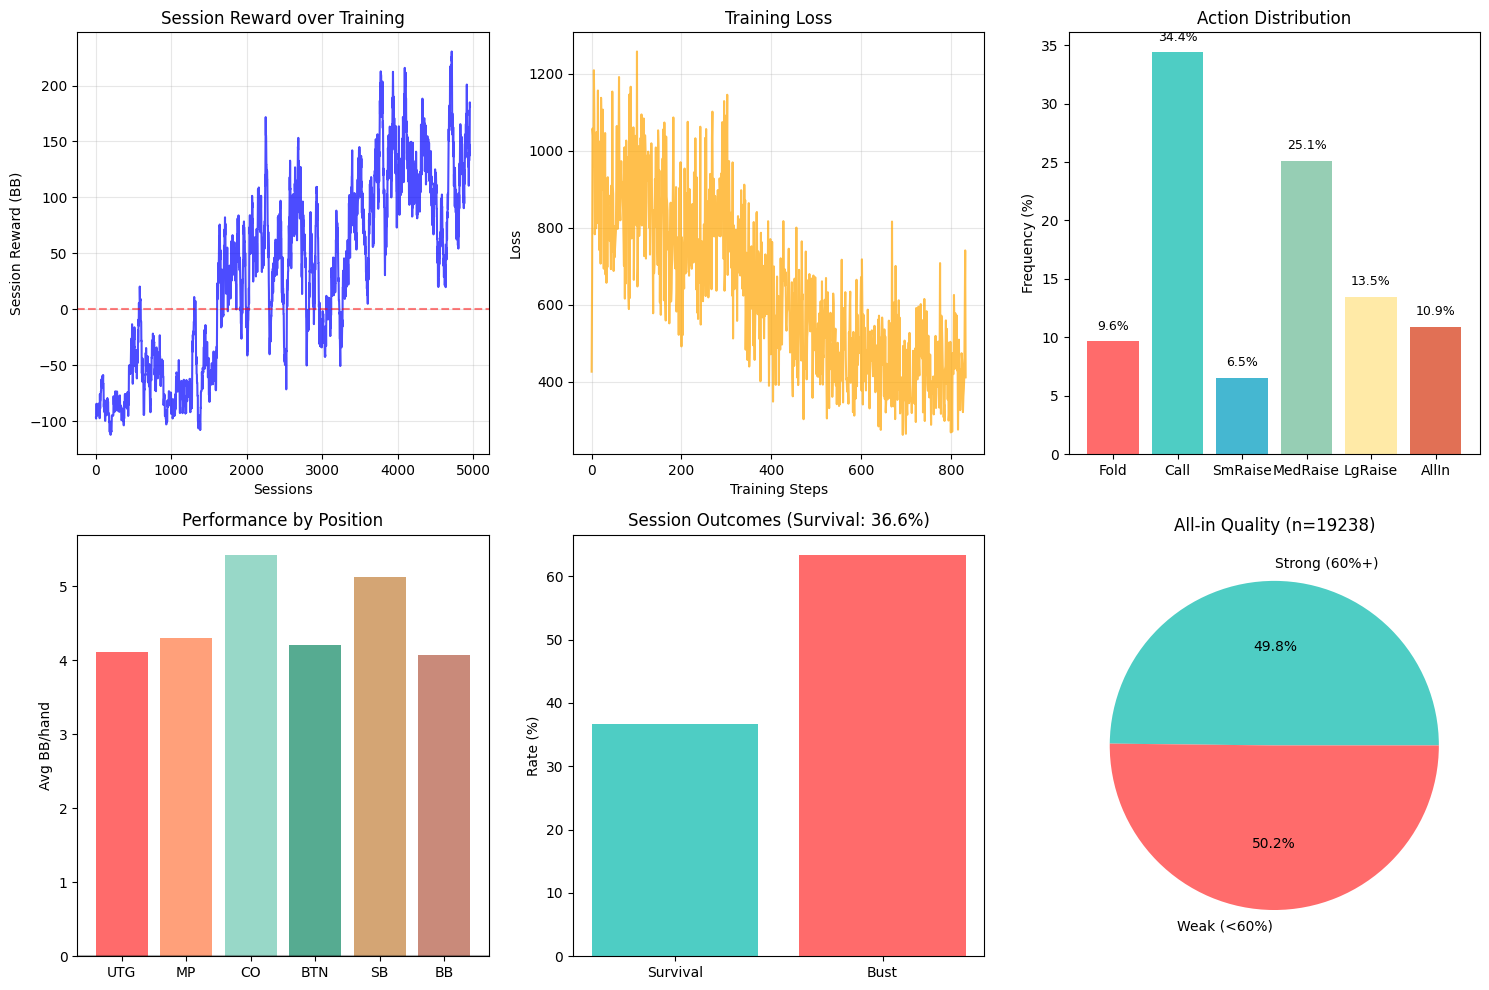

In [9]:
# Visualize training progress (same style as V15)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Session rewards over time
ax = axes[0, 0]
window = 50
if len(history['rewards']) > window:
    smoothed = np.convolve(history['rewards'], np.ones(window)/window, mode='valid')
    ax.plot(smoothed, 'b-', alpha=0.7)
else:
    ax.plot(history['rewards'], 'b-', alpha=0.7)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Sessions')
ax.set_ylabel('Session Reward (BB)')
ax.set_title('Session Reward over Training')
ax.grid(True, alpha=0.3)

# 2. Loss curve
ax = axes[0, 1]
if history['loss']:
    ax.plot(history['loss'], 'orange', alpha=0.7)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)

# 3. Action distribution
ax = axes[0, 2]
action_names = ['Fold', 'Call', 'SmRaise', 'MedRaise', 'LgRaise', 'AllIn']
total = sum(history['action_counts'].values())
pcts = [history['action_counts'][i]/total*100 if total > 0 else 0 for i in range(6)]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#e17055']
bars = ax.bar(action_names, pcts, color=colors)
ax.set_ylabel('Frequency (%)')
ax.set_title('Action Distribution')
for bar, val in zip(bars, pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.1f}%', ha='center', fontsize=9)

# 4. Position performance
ax = axes[1, 0]
pos_names = ['UTG', 'MP', 'CO', 'BTN', 'SB', 'BB']
pos_avgs = [np.mean(history['position_stats'][i]['rewards']) 
            if history['position_stats'][i]['rewards'] else 0 
            for i in range(6)]
bars = ax.bar(pos_names, pos_avgs, color=['#ff6b6b', '#ffa07a', '#98d8c8', '#56ab91', '#d4a574', '#c98a7a'])
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.set_ylabel('Avg BB/hand')
ax.set_title('Performance by Position')

# 5. Survival rate over time (V16 specific)
ax = axes[1, 1]
metrics = history['session_metrics']
survival_rate = metrics['survival_count'] / max(metrics['survival_count'] + metrics['bust_count'], 1) * 100
ax.bar(['Survival', 'Bust'], [survival_rate, 100 - survival_rate], color=['#4ecdc4', '#ff6b6b'])
ax.set_ylabel('Rate (%)')
ax.set_title(f'Session Outcomes (Survival: {survival_rate:.1f}%)')

# 6. All-in analysis (V16 specific)
ax = axes[1, 2]
if history['risk_metrics']['allin_count'] > 0:
    strong = history['risk_metrics']['allin_with_strong']
    weak = history['risk_metrics']['allin_with_weak']
    ax.pie([strong, weak], labels=['Strong (60%+)', 'Weak (<60%)'], 
           colors=['#4ecdc4', '#ff6b6b'], autopct='%1.1f%%')
    ax.set_title(f'All-in Quality (n={strong+weak})')
else:
    ax.text(0.5, 0.5, 'No all-ins', ha='center', va='center')
    ax.set_title('All-in Quality')

plt.tight_layout()
plt.savefig('v16_training_results.png', dpi=150)
plt.show()